# Simulated Audiogram Estimation - Modified Hughson Westlake
Run on `bayes_audiogram` conda env

In [1]:
import sys
sys.path.append( '../src/' )
from hearing_level_gen import *
from hearing_level_estimation import *
from hearing_level_visuals import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress the future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Generate exemplar hearing profiles

In [2]:
np.random.seed(0)  # For reproducibility

In [3]:
# generate 3 exemplar hearing profiles (normal hearing, age-related SNHL and, noise-induced or notched SNHL)
# normal hearing
x_data, normal_data = generate_clipped_data(n_points=8000, mu=10, variance=5, data_min=0, data_max=20)

# age-related SNHL
age_snhl_data = modulate_sigmoidal(normal_data, 2000, 0.001, 60)

# noise-induced or notched SNHL
notch_snhl_data = modulate_sigmoidal(normal_data, 3000, 0.01, 40)
notch_snhl_data = modulate_sigmoidal(notch_snhl_data, 7000, 0.01, -40)

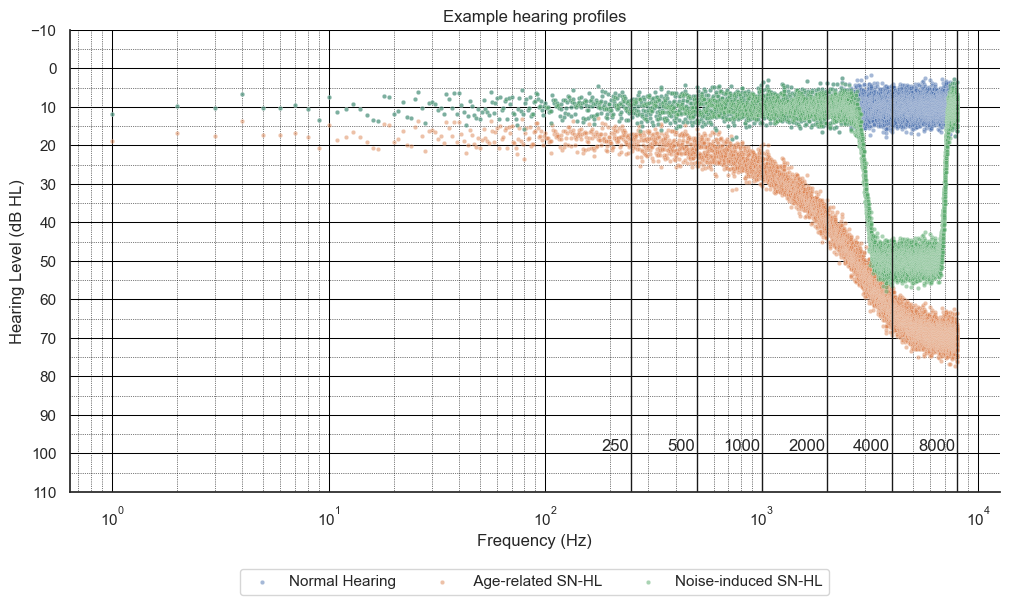

In [4]:
# plot the three exemplar hearing profiles
example_datasets = [(normal_data, 'Normal Hearing'),
                    (age_snhl_data, ' Age-related SN-HL'),
                    (notch_snhl_data, 'Noise-induced SN-HL')]

# Set the Seaborn theme to use a blank background
sns.set_theme(style="white")

# Use a Seaborn color palette
colors = sns.color_palette('deep', n_colors=len(example_datasets))

# Plot the exemplar datasets
plt.figure(figsize=(12, 6))
for i, example_dataset in enumerate(example_datasets):
    sns.scatterplot(x=x_data, y=example_dataset[0], color=colors[i], alpha=0.5, label=example_dataset[1], s=10)
    
# Adjust spines to only show left and bottom
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Set gridlines
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax.grid(which='major', color='black', linestyle='-', linewidth=0.75)
ax.grid(which='minor', color='black', linestyle=':', linewidth=0.5)

# set log scaling
plt.xscale('log')

# Add vertical lines and labels at specified frequencies
frequencies = [250, 500, 1000, 2000, 4000, 8000]
for freq in frequencies:
    plt.axvline(x=freq, color='k', linestyle='-', linewidth=1)
    plt.text(freq-(freq/50), 100, str(freq), ha='right', va='bottom')

plt.title('Example hearing profiles')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hearing Level (dB HL)')
plt.ylim(-10, 110)
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=False, ncol=3)
plt.show()

### Plot the audiogram curves of the 3 example "participants"

In [4]:
def thresholds_to_curve(df, split=False, title=None):
    """
    Generates a subplot of audiogram curves for each participant in the dataframe,
    arranging the subplots in a grid that minimizes the difference between the number of rows and columns.
    If split is True, it creates separate subplots for each ear.

    Args:
    df (pandas.DataFrame): A dataframe where each row represents a participant's
                           hearing thresholds at different frequencies for both ears.
                           Expected columns are '0.5kHz Left', '1kHz Left', '2kHz Left',
                           '4kHz Left', '8kHz Left', '0.5kHz Right', '1kHz Right',
                           '2kHz Right', '4kHz Right', '8kHz Right', with some flexibility in naming.
    split (bool): If True, creates separate subplots for each ear. Default is False.
    title (str): Title for the plot. If None, no title is set. For split view, this will be used as a base title.

    Raises:
    ValueError: If the DataFrame does not contain the expected columns.
    """
    # Define the required frequencies and ears
    freqs = ['0.5', '1', '2', '4', '8']
    ears = ['Right', 'Left']

    # Function to check if a column exists with a specific frequency and ear
    def has_column(freq, ear):
        return any(f"{freq}kHz {ear}" in col or f"{freq}.0kHz {ear}" in col for col in df.columns)

    # Check if the dataframe contains all the required columns
    if not all(has_column(freq, ear) for freq in freqs for ear in ears):
        raise ValueError("DataFrame does not contain all required frequency columns for both ears.")

    # Define color palette
    palette = sns.color_palette("deep")
    red = palette[3]
    blue = palette[0]

    # Determine number of participants and grid layout
    num_participants = df.shape[0]
    if split:
        n_cols = math.ceil(math.sqrt(num_participants * 2))
        n_rows = math.ceil((num_participants * 2) / n_cols)
    else:
        n_cols = math.ceil(math.sqrt(num_participants))
        n_rows = math.ceil(num_participants / n_cols)

    # Create a figure with subplots arranged in a grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True, sharey=True)

    # Set the main title if provided
    if title:
        if split:
            fig.suptitle(title, fontsize=16, y=1.02)
        else:
            fig.suptitle(title, fontsize=16)

    # Check if axes is a single Axes object or an array of Axes objects
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    # Plot each participant's data
    for idx, (_, row) in enumerate(df.iterrows()):
        if split:
            ax_right = axes.flat[idx * 2]
            ax_left = axes.flat[idx * 2 + 1]
        else:
            ax = axes.flat[idx]

        for ear, color, marker in [('Right', red, 'X'), ('Left', blue, 'o')]:
            data = []
            sorted_freqs = []
            for freq in freqs:
                for col in df.columns:
                    if f"{freq}kHz {ear}" in col or f"{freq}.0kHz {ear}" in col:
                        data.append(row[col])
                        sorted_freqs.append(freq)
                        break

            if split:
                ax = ax_right if ear == 'Right' else ax_left
                ax.set_title(f'{title} - {ear} Ear' if title else '')
            else:
                ax.set_title(f'{title}' if title else '')

            if marker == 'o':
                ax.plot(sorted_freqs, data, label=f'{ear} Ear', marker=marker, linestyle='-',
                        color=color, markersize=10, lw=2, markeredgewidth=2,
                        markerfacecolor='none', markeredgecolor=color)  # Hollow circle for Left ear
            elif marker == 'X':
                ax.plot(sorted_freqs, data, label=f'{ear} Ear', marker=marker, linestyle='-',
                        color=color, markersize=12, lw=2, markerfacecolor=color,
                        markeredgecolor='white', markeredgewidth=1)
            
            ax.set_xlabel('Frequency (kHz)')
            ax.set_ylabel('Hearing Level (dB)')
            ax.invert_yaxis()
            ax.set_ylim(120, -20)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks(freqs)
            ax.set_yticks(np.arange(-20, 130, 10))

    # Turn off unused subplots
    for idx in range(num_participants * (2 if split else 1), len(axes.flat)):
        axes.flat[idx].axis('off')

    # Create an overall legend and adjust layout
    fig.legend(['Right Ear', 'Left Ear'], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    
    plt.tight_layout()
    plt.show()

def myround(x, base=5):
    return base * round(x/base)

   0.5kHz Right  1.0kHz Right  2.0kHz Right  4.0kHz Right  8.0kHz Right
0          10.0          10.0          10.0          15.0          10.0

   0.5kHz Left  1.0kHz Left  2.0kHz Left  4.0kHz Left  8.0kHz Left
0         10.0         10.0         10.0         15.0         10.0


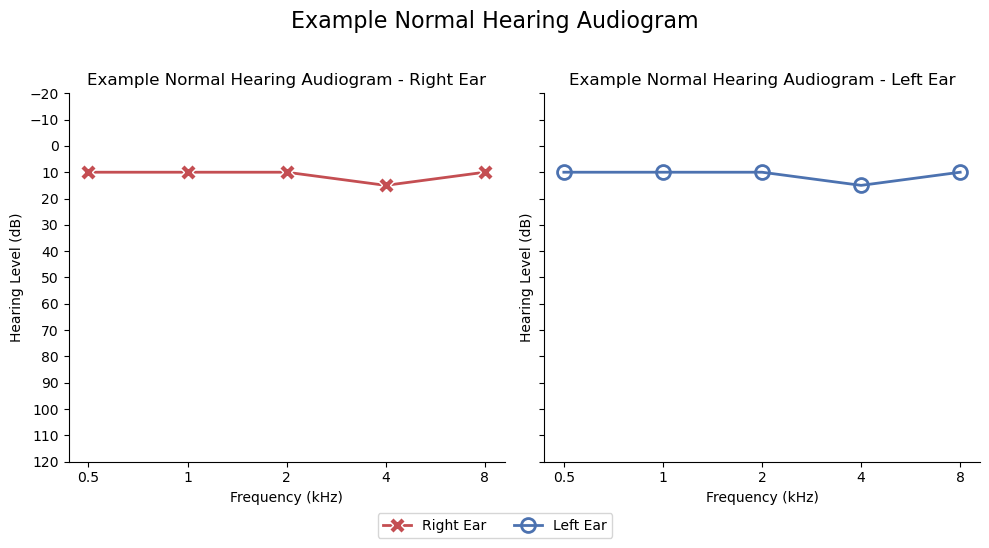

In [5]:
# create data frame of hearing profile with noise induced HL on the left side
normal_hl_df = synth_to_dataframe([500, 1000, 2000, 4000, 8000], normal_data, normal_data).apply(lambda x: myround(x, base=5))
print(normal_hl_df[[column for column in normal_hl_df.columns if column.endswith('Right')]])
print()
print(normal_hl_df[[column for column in normal_hl_df.columns if column.endswith('Left')]])
thresholds_to_curve(normal_hl_df, split=True, title='Example Normal Hearing Audiogram')
plt.show()

   0.5kHz Right  1.0kHz Right  2.0kHz Right  4.0kHz Right  8.0kHz Right
0          10.0          10.0          10.0          15.0          10.0

   0.5kHz Left  1.0kHz Left  2.0kHz Left  4.0kHz Left  8.0kHz Left
0         10.0         10.0         10.0         55.0         10.0


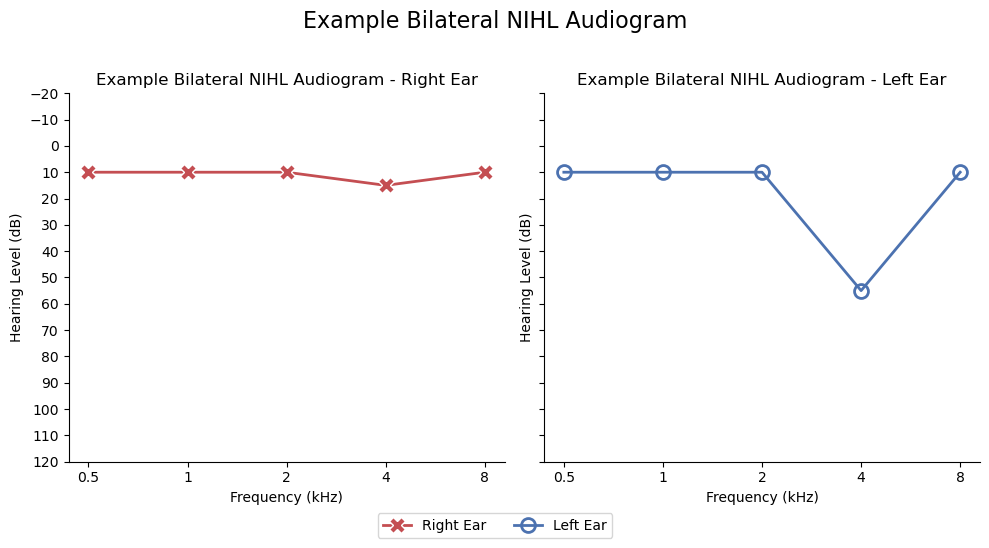

In [6]:
# create data frame of hearing profile with noise induced HL on the left side
bilateral_notch_hl_df = synth_to_dataframe([500, 1000, 2000, 4000, 8000], normal_data, notch_snhl_data).apply(lambda x: myround(x, base=5))
print(bilateral_notch_hl_df[[column for column in bilateral_notch_hl_df.columns if column.endswith('Right')]])
print()
print(bilateral_notch_hl_df[[column for column in bilateral_notch_hl_df.columns if column.endswith('Left')]])
thresholds_to_curve(bilateral_notch_hl_df, split=True, title='Example Bilateral NIHL Audiogram')
plt.show()

   0.5kHz Right  1.0kHz Right  2.0kHz Right  4.0kHz Right  8.0kHz Right
0          25.0          30.0          40.0          65.0          70.0

   0.5kHz Left  1.0kHz Left  2.0kHz Left  4.0kHz Left  8.0kHz Left
0         25.0         30.0         40.0         65.0         70.0


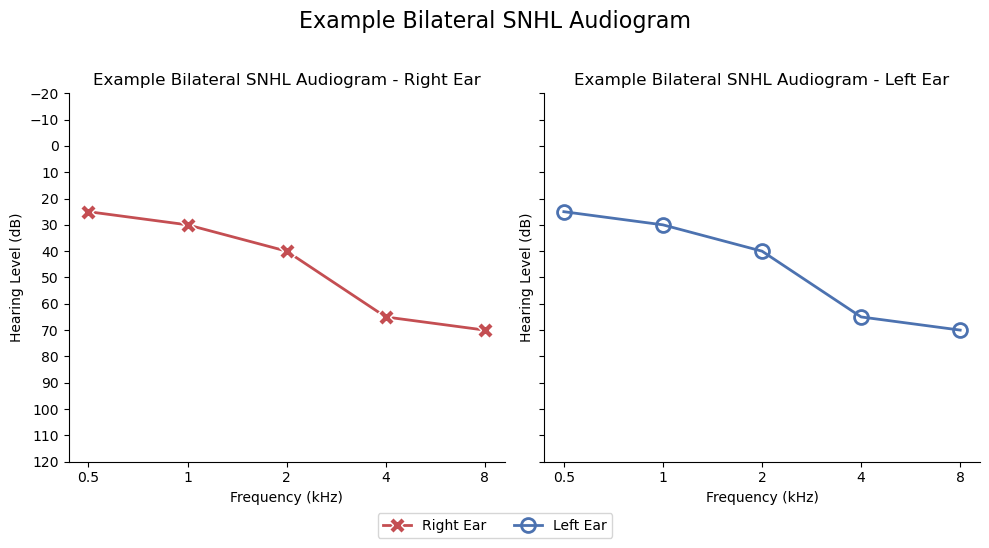

In [7]:
# create data frame of hearing profile with noise induced HL on the left side
unilateral_snhl_df = synth_to_dataframe([500, 1000, 2000, 4000, 8000], age_snhl_data, age_snhl_data).apply(lambda x: myround(x, base=5))
print(unilateral_snhl_df[[column for column in unilateral_snhl_df.columns if column.endswith('Right')]])
print()
print(unilateral_snhl_df[[column for column in unilateral_snhl_df.columns if column.endswith('Left')]])
thresholds_to_curve(unilateral_snhl_df, split=True, title='Example Bilateral SNHL Audiogram')
plt.show()

### Multiple samples from hearing profiles
Next, we will use the initialised hearing profile above as the "True" hearing level of an individual. When performing a pure-tone hearing-level test at a specific frequency, we can postulate a further level of variability (in-test). From the data above, sampling at 500 Hz would provide the same HL response every time; which is highly unrealistic. We can use the profile generator to then be a reference point for a further level of sampling. There are feasibly multiple different distributions that observed pure-tone hearing-levels could take, but for simplicity we will assume a Gaussian.

In [8]:
# specify test frequencies
pure_tone_freqs = [250, 500, 1000, 2000, 4000, 8000]

# init dataframe for samples
normal_hearing_sampled_df = pd.DataFrame({
    '250': [],
    '500': [],
    '1000': [],
    '2000': [],
    '4000': [],
    '8000': [],
})

for pure_tone_freq_i in pure_tone_freqs:
    samples_i = pure_tone_sample(normal_data, pure_tone_freq_i, 2.5, 50)
    normal_hearing_sampled_df[str(pure_tone_freq_i)] = samples_i

# init dataframe for age-related snhl
age_snhl_sampled_df = pd.DataFrame({
    '250': [],
    '500': [],
    '1000': [],
    '2000': [],
    '4000': [],
    '8000': [],
})

for pure_tone_freq_i in pure_tone_freqs:
    samples_i = pure_tone_sample(age_snhl_data, pure_tone_freq_i, 5, 50)
    age_snhl_sampled_df[str(pure_tone_freq_i)] = samples_i

# init dataframe for noise-induced snhl
notch_snhl_sampled_df = pd.DataFrame({
    '250': [],
    '500': [],
    '1000': [],
    '2000': [],
    '4000': [],
    '8000': [],
})

for pure_tone_freq_i in pure_tone_freqs:
    samples_i = pure_tone_sample(notch_snhl_data, pure_tone_freq_i, 2.5, 50)
    notch_snhl_sampled_df[str(pure_tone_freq_i)] = samples_i

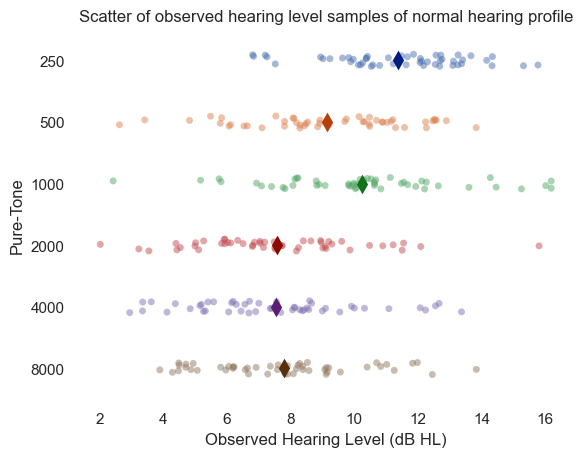

In [11]:
# "Melt" the dataset to "long-form" or "tidy" representation
normal_hearing_sampled_long = normal_hearing_sampled_df.melt(var_name="Pure-Tone", value_name="Observed Hearing Level (dB HL)")
normal_hearing_sampled_long = normal_hearing_sampled_long.replace([np.inf, -np.inf], np.nan)

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
ax = sns.stripplot(
    data=normal_hearing_sampled_long, x="Observed Hearing Level (dB HL)", y="Pure-Tone", hue="Pure-Tone",
    dodge=False, alpha=.5, zorder=1, legend=False,
)
ax = sns.pointplot(
    data=normal_hearing_sampled_long, x="Observed Hearing Level (dB HL)", y="Pure-Tone", hue="Pure-Tone",
    dodge=False, palette="dark", errorbar=None,
    markers="d", 
)
ax.set_title('Scatter of observed hearing level samples of normal hearing profile')
#ax.legend_.remove()
plt.show()

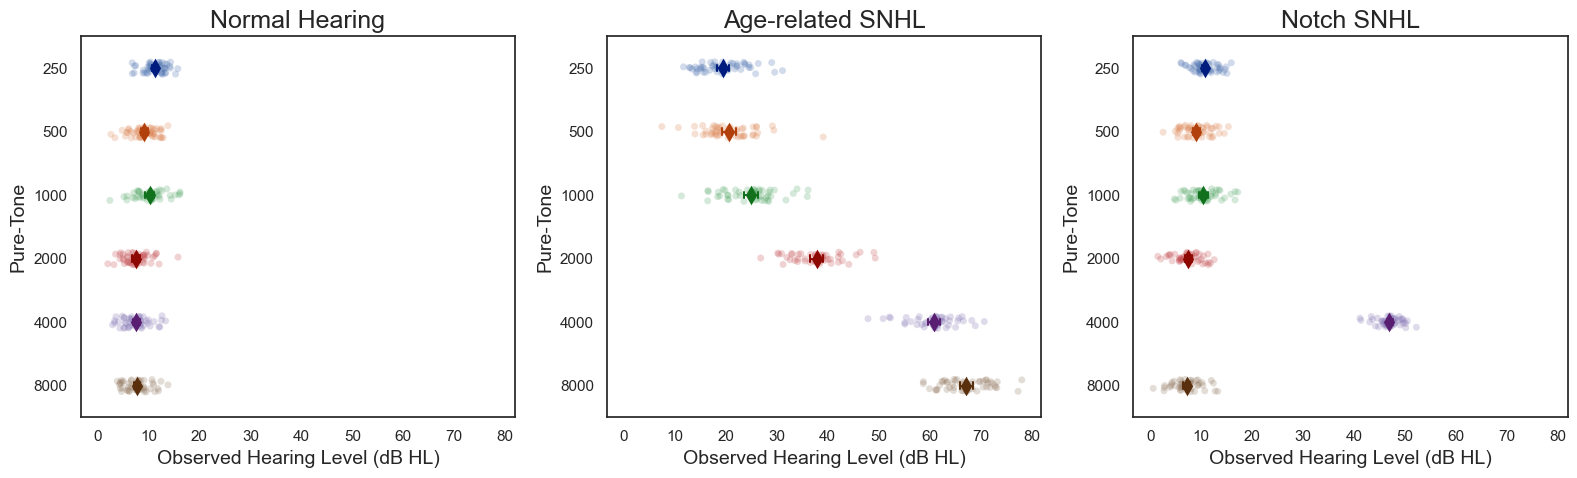

In [14]:
# Function to preprocess the data using melt
def preprocess_data(df):
    df_long = df.melt(var_name="Pure-Tone", value_name="Observed Hearing Level (dB HL)")
    df_long = df_long.replace([np.inf, -np.inf], np.nan)
    return df_long

# Preprocess the datasets
normal_hearing_sampled_long = preprocess_data(normal_hearing_sampled_df)
age_snhl_sampled_long = preprocess_data(age_snhl_sampled_df)
notch_snhl_sampled_long = preprocess_data(notch_snhl_sampled_df)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True)

# Plotting settings
strip_plot_params = {
    "dodge": False,
    "alpha": 0.25,
    "zorder": 1,
    "legend": False,
}

point_plot_params = {
    "dodge": False,
    "markers": "d",
    "errwidth": 1.5,  # Set the width of the error bars
    "capsize": 0.1,   # Set the size of the error bar caps
}

# Increase font sizes
plt.rcParams.update({'font.size': 14})  # Increase overall font size
title_size = 18  # Specify the desired title font size
label_size = 14  # Specify the desired label font size

# Plot normal hearing data
sns.stripplot(data=normal_hearing_sampled_long, x="Observed Hearing Level (dB HL)", y="Pure-Tone", hue="Pure-Tone", ax=axs[0], **strip_plot_params)
sns.pointplot(data=normal_hearing_sampled_long, x="Observed Hearing Level (dB HL)", y="Pure-Tone", hue="Pure-Tone", ax=axs[0], palette="dark", **point_plot_params)
axs[0].set_title("Normal Hearing", fontsize=title_size)
axs[0].set_xlabel("Observed Hearing Level (dB HL)", fontsize=label_size)
axs[0].set_ylabel("Pure-Tone", fontsize=label_size)

# Plot age-related SNHL data
sns.stripplot(data=age_snhl_sampled_long, x="Observed Hearing Level (dB HL)", y="Pure-Tone", hue="Pure-Tone", ax=axs[1], **strip_plot_params)
sns.pointplot(data=age_snhl_sampled_long, x="Observed Hearing Level (dB HL)", y="Pure-Tone", hue="Pure-Tone", ax=axs[1], palette="dark", **point_plot_params)
axs[1].set_title("Age-related SNHL", fontsize=title_size)
axs[1].set_xlabel("Observed Hearing Level (dB HL)", fontsize=label_size)
axs[1].set_ylabel("Pure-Tone", fontsize=label_size)

# Plot notch SNHL data
sns.stripplot(data=notch_snhl_sampled_long, x="Observed Hearing Level (dB HL)", y="Pure-Tone", hue="Pure-Tone", ax=axs[2], **strip_plot_params)
sns.pointplot(data=notch_snhl_sampled_long, x="Observed Hearing Level (dB HL)", y="Pure-Tone", hue="Pure-Tone", ax=axs[2], palette="dark", **point_plot_params)
axs[2].set_title("Notch SNHL", fontsize=title_size)
axs[2].set_xlabel("Observed Hearing Level (dB HL)", fontsize=label_size)
axs[2].set_ylabel("Pure-Tone", fontsize=label_size)

# Adjust spacing between subplots
plt.tight_layout()

#plt.savefig('../figures/audiogram_profiles.png', dpi=400)
plt.show()

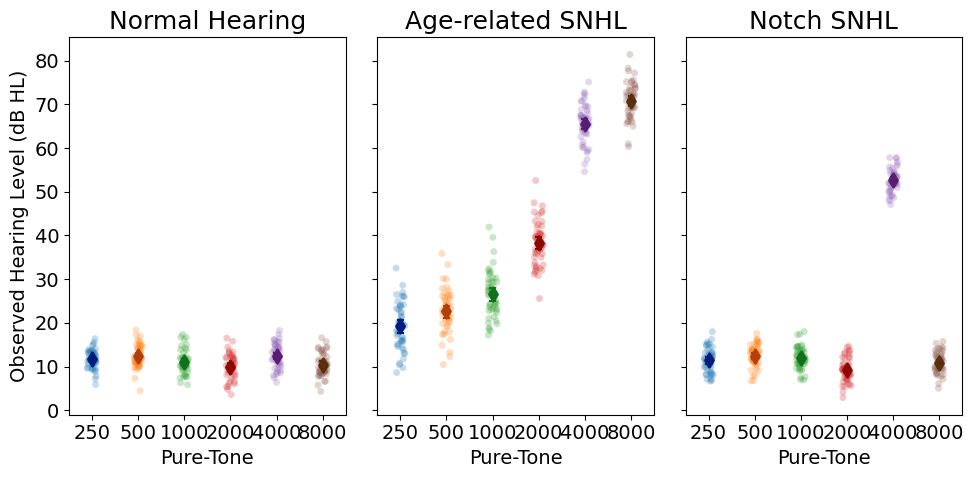

In [11]:
# Function to preprocess the data using melt
def preprocess_data(df):
    df_long = df.melt(var_name="Pure-Tone", value_name="Observed Hearing Level (dB HL)")
    df_long = df_long.replace([np.inf, -np.inf], np.nan)
    return df_long

# Preprocess the datasets
normal_hearing_sampled_long = preprocess_data(normal_hearing_sampled_df)
age_snhl_sampled_long = preprocess_data(age_snhl_sampled_df)
notch_snhl_sampled_long = preprocess_data(notch_snhl_sampled_df)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

# Plotting settings
strip_plot_params = {
    "dodge": False,
    "alpha": 0.25,
    "zorder": 1,
    "legend": False,
}

point_plot_params = {
    "dodge": False,
    "markers": "d",
    "errwidth": 1.5,  # Set the width of the error bars
    "capsize": 0.1,   # Set the size of the error bar caps
}

# Increase font sizes
plt.rcParams.update({'font.size': 14})  # Increase overall font size
title_size = 18  # Specify the desired title font size
label_size = 14  # Specify the desired label font size

# Plot normal hearing data
sns.stripplot(data=normal_hearing_sampled_long, y="Observed Hearing Level (dB HL)", x="Pure-Tone", hue="Pure-Tone", ax=axs[0], **strip_plot_params)
sns.pointplot(data=normal_hearing_sampled_long, y="Observed Hearing Level (dB HL)", x="Pure-Tone", hue="Pure-Tone", ax=axs[0], palette="dark", **point_plot_params)
axs[0].set_title("Normal Hearing", fontsize=title_size)
axs[0].set_ylabel("Observed Hearing Level (dB HL)", fontsize=label_size)
axs[0].set_xlabel("Pure-Tone", fontsize=label_size)
axs[0].legend_.remove()

# Plot age-related SNHL data
sns.stripplot(data=age_snhl_sampled_long, y="Observed Hearing Level (dB HL)", x="Pure-Tone", hue="Pure-Tone", ax=axs[1], **strip_plot_params)
sns.pointplot(data=age_snhl_sampled_long, y="Observed Hearing Level (dB HL)", x="Pure-Tone", hue="Pure-Tone", ax=axs[1], palette="dark", **point_plot_params)
axs[1].set_title("Age-related SNHL", fontsize=title_size)
axs[1].set_ylabel("Observed Hearing Level (dB HL)", fontsize=label_size)
axs[1].set_xlabel("Pure-Tone", fontsize=label_size)
axs[1].legend_.remove()

# Plot notch SNHL data
sns.stripplot(data=notch_snhl_sampled_long, y="Observed Hearing Level (dB HL)", x="Pure-Tone", hue="Pure-Tone", ax=axs[2], **strip_plot_params)
sns.pointplot(data=notch_snhl_sampled_long, y="Observed Hearing Level (dB HL)", x="Pure-Tone", hue="Pure-Tone", ax=axs[2], palette="dark", **point_plot_params)
axs[2].set_title("Notch SNHL", fontsize=title_size)
axs[2].set_ylabel("Observed Hearing Level (dB HL)", fontsize=label_size)
axs[2].set_xlabel("Pure-Tone", fontsize=label_size)
axs[2].legend_.remove()

# Adjust spacing between subplots
plt.tight_layout()

#plt.savefig('../figures/audiogram_profiles.png', dpi=400)
plt.show()

## Modified Hughson-Westlake Procedure
The below code provides a demonstration of the modified Hughson-Westlake (HW) procedure applied to the generated hearing level data. Specifically, this follows the BSA recommended procedure (2017). Given different hearing profiles, the code below can return:

1. The individuals estimated hearing level threshold at each test pure-tone
2. The familiarisation level required to start testing
3. The progression of the testing levels (i.e., Test 0 @ 40 dB HL = Response, Test 1 @ 30 dB HL - No response, etc.)

These have been added to `hearing_level_estimation.py`

In [13]:
def _get_initial_familiarization_level(samples_i, familiarization_level):
    """
    Determines the initial familiarization level based on the provided samples.

    Args:
        samples_i (numpy.ndarray): Array of samples representing the true hearing level.
        familiarization_level (float or None): The current familiarization level, if available.

    Returns:
        float: The initial familiarization level.
    """
    if familiarization_level is None:
        test_level = 40  # Starting level for initial familiarization.
        true_level = samples_i.mean()
        while not respond(test_level, true_level):
            if test_level < 80:
                test_level += 10
            elif test_level > 80:
                test_level += 5  # Increase in smaller increments above 80 dB HL.
            elif test_level == 125: # Exit with None - i.e., not reached - if over 120
                test_level = None
        familiarization_level = test_level

    return familiarization_level


def _update_progression(progression, test_level, response, responses, n_tests, phase):
    """
    Updates the progression list with the current test level, response, and phase.

    Args:
        progression (list): List to store the progression data.
        test_level (int): Current test level.
        response (bool): True if the patient responded, False otherwise.
        responses (dict): Dictionary to store the number of positive responses at each test level.
        n_tests (dict): Dictionary to store the total number of tests at each test level.
        phase (str): Phase of the test (e.g., 'initial_response', 'ascend').
    """
    progression.append((test_level, response, f"{responses[test_level]}/{n_tests[test_level]}", phase))


def _increase_test_level(test_level, initial_no_response):
    """
    Increases the test level based on the initial_no_response flag.

    Args:
        test_level (int): Current test level.
        initial_no_response (bool): True if no response has been recorded yet, False otherwise.

    Returns:
        int: The new test level.
    """
    if initial_no_response:
        if test_level <= 80:
            test_level += 10
        else:
            test_level += 5
    else:
        test_level += 5

    return test_level


def _descend_and_ascend(test_level, true_level, samples_i, n_attempts, responses, n_tests, progression):
    """
    Performs the descend and ascend steps of the modified Hughson-Westlake procedure.

    Args:
        test_level (int): Current test level.
        true_level (float): True hearing level of the patient.
        samples_i (numpy.ndarray): Array of samples representing the true hearing level.
        n_attempts (int): Number of attempts made so far.
        responses (dict): Dictionary to store the number of positive responses at each test level.
        n_tests (dict): Dictionary to store the total number of tests at each test level.
        progression (list): List to store the progression data.

    Returns:
        tuple: A tuple containing the new test level, response, true level, number of attempts, and phase.
    """
    test_level -= 10
    n_attempts += 1
    if n_attempts < len(samples_i):
        true_level = samples_i[n_attempts]

    response = respond(test_level, true_level)
    phase = 'descend'
    _update_progression(progression, test_level, response, responses, n_tests, phase)

    if not response:
        phase = 'ascend'
        test_level, true_level, responses, n_tests, progression = _ascend(
            test_level, true_level, samples_i, n_attempts, responses, n_tests, progression)

    return test_level, response, true_level, n_attempts, phase


def _ascend(test_level, true_level, samples_i, n_attempts, responses, n_tests, progression):
    """
    Performs the ascend step of the modified Hughson-Westlake procedure.

    Args:
        test_level (int): Current test level.
        true_level (float): True hearing level of the patient.
        samples_i (numpy.ndarray): Array of samples representing the true hearing level.
        n_attempts (int): Number of attempts made so far.
        responses (dict): Dictionary to store the number of positive responses at each test level.
        n_tests (dict): Dictionary to store the total number of tests at each test level.
        progression (list): List to store the progression data.

    Returns:
        tuple: A tuple containing the new test level, true level, responses, n_tests, and progression.
    """
    while not respond(test_level, true_level):
        test_level += 5
        n_attempts += 1
        if n_attempts < len(samples_i):
            true_level = samples_i[n_attempts]

        response = respond(test_level, true_level)
        n_tests[test_level] += 1
        if response:
            responses[test_level] += 1
        _update_progression(progression, test_level, response, responses, n_tests, 'ascend')

    return test_level, true_level, responses, n_tests, progression


def _threshold_found(responses, n_tests, test_level):
    """
    Checks if the threshold has been found based on the response ratio.

    Args:
        responses (dict): Dictionary to store the number of positive responses at each test level.
        n_tests (dict): Dictionary to store the total number of tests at each test level.
        test_level (int): Current test level.

    Returns:
        bool: True if the threshold has been found, False otherwise.
    """
    return responses[test_level] > 1 and responses[test_level] / n_tests[test_level] > 0.5

def _find_threshold(frequency, hearing_profile_data, pure_tone_sample_params,
                    familiarization_level, random_state=None, max_attempts=10):
    """
    Finds the hearing threshold for a specific frequency using the modified Hughson-Westlake method.
    Includes error handling for missing frequency data.

    Args:
        frequency (int): The test frequency in Hz.
        hearing_profile_data (dict): Data containing hearing thresholds.
        pure_tone_sample_params (dict): Parameters for generating samples.
        familiarization_level (float): The starting level of testing based on previous tests.
        random_state (int): Seed for random operations to ensure reproducibility.

    Returns:
        tuple: Returns the current familiarization level, determined threshold, and the progression pattern.
    """
    try:
        samples_i = pure_tone_sample(hearing_profile_data, frequency,
                                     **pure_tone_sample_params,
                                     random_state=random_state)
    except KeyError:
        print(f"Warning: Frequency {frequency} not found in hearing_profile_data. Skipping.")
        return familiarization_level, None, []

    familiarization_level = _get_initial_familiarization_level(samples_i, familiarization_level)

    test_level = familiarization_level - 10  # Begin testing 10 dB below the familiarization level.
    true_level = samples_i.mean()  # Reset true level for threshold search.
    threshold = None
    responses = {i: 0 for i in range(-20, 121, 5)}
    n_tests = {i: 0 for i in range(-20, 121, 5)}
    progression = []
    threshold_found = False
    initial_no_response = True
    n_attempts = 0
    phase = 'initial_response'

    while not respond(test_level, true_level):
        _update_progression(progression, test_level, False, responses, n_tests, phase)
        test_level = _increase_test_level(test_level, initial_no_response)

    initial_no_response = False
    _update_progression(progression, test_level, True, responses, n_tests, phase)

    n_attempts = 0
    while not threshold_found or n_attempts<max_attempts:
        test_level, response, true_level, n_attempts, phase = _descend_and_ascend(
            test_level, true_level, samples_i, n_attempts, responses, n_tests, progression)

        if _threshold_found(responses, n_tests, test_level):
            threshold = test_level
            threshold_found = True
        
        n_attempts+=1

    return familiarization_level, threshold, progression

def _check_and_test_inter_octave_frequencies(freq, thresholds, progression_patterns,
                                             hearing_profile_data, pure_tone_sample_params,
                                             familiarization_level, random_state):
    """
    Checks for significant gaps between octave thresholds and tests intermediate frequencies if necessary.

    Args:
        freq (int): The current test frequency.
        thresholds (dict): Dictionary containing the determined thresholds.
        progression_patterns (dict): Dictionary containing the progression patterns.
        hearing_profile_data (dict): Dictionary containing hearing profile data.
        pure_tone_sample_params (dict): Parameters for generating pure tone samples.
        familiarization_level (float): The current familiarization level.
        random_state (int): Seed for random operations to ensure reproducibility.
    """
    octave_higher = freq * 2
    octave_lower = freq // 2

    if octave_higher in thresholds:
        if abs(thresholds[freq] - thresholds[octave_higher]) >= 20:
            inter_octave_freq = int((freq + octave_higher) / 2)
            if inter_octave_freq not in thresholds:
                familiarization_level, thresholds[inter_octave_freq], progression_patterns[inter_octave_freq] = \
                    _find_threshold(inter_octave_freq, hearing_profile_data,
                                    pure_tone_sample_params, familiarization_level, random_state)

    if octave_lower in thresholds:
        if abs(thresholds[freq] - thresholds[octave_lower]) >= 20:
            inter_octave_freq = int((freq + octave_lower) / 2)
            if inter_octave_freq not in thresholds:
                familiarization_level, thresholds[inter_octave_freq], progression_patterns[inter_octave_freq] = \
                    _find_threshold(inter_octave_freq, hearing_profile_data,
                                    pure_tone_sample_params, familiarization_level, random_state)


def respond(test_level, true_level):
    """
    Simulates a patient's response to a tone presentation.

    Args:
        test_level (int): Current test level.
        true_level (float): True hearing level of the patient.

    Returns:
        bool: True if the patient is expected to respond, False otherwise.
    """
    return test_level >= true_level

def modified_hughson_westlake_procedure(test_frequencies, hearing_profile_data,
                                        pure_tone_sample_params, random_state=None):
    """
    Performs the modified Hughson-Westlake procedure for pure-tone audiometry.
    This procedure adapts the standard audiometric testing by considering initial
    non-responses and detailed progression tracking.

    Args:
        test_frequencies (list): List of frequencies (Hz) to be tested.
        hearing_profile_data (dict): Dictionary containing hearing profile data.
        pure_tone_sample_params (dict): Parameters for generating pure tone samples.
        random_state (int, optional): Seed for the random number generator to ensure reproducibility.

    Returns:
        tuple: A tuple containing the familiarization level, thresholds at each test frequency,
               and progression patterns detailing the testing steps and outcomes.
    """
    thresholds = {}
    progression_patterns = {}
    familiarization_level = None  # Initialize familiarization level for the first frequency tested.

    for freq in test_frequencies:
        familiarization_level, thresholds[freq], progression_patterns[freq] = _find_threshold(
            freq, hearing_profile_data, pure_tone_sample_params, familiarization_level, random_state)

        _check_and_test_inter_octave_frequencies(freq, thresholds, progression_patterns,
                                                 hearing_profile_data, pure_tone_sample_params,
                                                 familiarization_level, random_state)

    # Retest at 1000 Hz for consistency.
    if 1000 in test_frequencies:
        _, retest_threshold, _ = _find_threshold(1000, hearing_profile_data, pure_tone_sample_params, familiarization_level)
        if abs(retest_threshold - thresholds[1000]) > 5:
            print("Retest at 1000 Hz differs by more than 5 dB.")
        thresholds[1000] = min(thresholds[1000], retest_threshold)

    return familiarization_level, thresholds, progression_patterns

In [55]:
pure_tone_sample_params = {'noise':5, 'n_samples':100}

familiarization_level, \
test_thresholds, \
progression_patterns = modified_hughson_westlake_procedure([1000, 2000, 4000, 8000, 500, 250],
                                                           notch_snhl_data,
                                                           pure_tone_sample_params,
                                                           random_state=1)

In [56]:
print(f'Results of mHW-procedure for a simulated patient with noise-induced hearing loss. \n\nFamiliarisation level: {familiarization_level} \n\nTest Thresholds:\n{test_thresholds}.')


Results of mHW-procedure for a simulated patient with noise-induced hearing loss. 

Familiarisation level: 40 

Test Thresholds:
{1000: 15, 2000: 15, 4000: 55, 3000: 30, 8000: 15, 6000: 50, 500: 15, 250: 15}.


In [58]:
progression_patterns

{1000: [(30, True, '0/0', 'initial_response'),
  (20, True, '0/0', 'descend'),
  (10, True, '0/0', 'descend'),
  (0, False, '0/0', 'descend'),
  (5, False, '0/1', 'ascend'),
  (10, False, '0/1', 'ascend'),
  (15, True, '1/1', 'ascend'),
  (5, False, '0/1', 'descend'),
  (10, False, '0/2', 'ascend'),
  (15, True, '2/2', 'ascend'),
  (5, False, '0/1', 'descend'),
  (10, False, '0/3', 'ascend'),
  (15, True, '3/3', 'ascend')],
 2000: [(30, True, '0/0', 'initial_response'),
  (20, True, '0/0', 'descend'),
  (10, True, '0/0', 'descend'),
  (0, False, '0/0', 'descend'),
  (5, False, '0/1', 'ascend'),
  (10, False, '0/1', 'ascend'),
  (15, True, '1/1', 'ascend'),
  (5, False, '0/1', 'descend'),
  (10, False, '0/2', 'ascend'),
  (15, True, '2/2', 'ascend'),
  (5, False, '0/1', 'descend'),
  (10, True, '1/3', 'ascend')],
 4000: [(30, False, '0/0', 'initial_response'),
  (40, False, '0/0', 'initial_response'),
  (50, False, '0/0', 'initial_response'),
  (60, True, '0/0', 'initial_response'),
  (

In [59]:
for i in progression_patterns:
    print(f'{i}Hz: {len(progression_patterns[i])} attempts.')

1000Hz: 13 attempts.
2000Hz: 12 attempts.
4000Hz: 19 attempts.
3000Hz: 16 attempts.
8000Hz: 13 attempts.
6000Hz: 18 attempts.
500Hz: 13 attempts.
250Hz: 13 attempts.


#### Class version

In [21]:
class ModifiedHughsonWestlakeAudiometry:
    def __init__(self, hearing_profile_data, pure_tone_sample_params, random_state=None):
        self.hearing_profile_data = hearing_profile_data
        self.pure_tone_sample_params = pure_tone_sample_params
        self.random_state = random_state
        self.familiarization_level = None
        self.thresholds = {}
        self.progression_patterns = {}

    def _find_threshold(self, frequency):
        """
        Finds the hearing threshold for a specific frequency using the modified Hughson-Westlake method.
        Includes error handling for missing frequency data.

        Args:
            frequency (int): The test frequency in Hz.

        Returns:
            tuple: Returns the current familiarization level, determined threshold, and the progression pattern.
        """
        try:
            samples_i = pure_tone_sample(self.hearing_profile_data, frequency,
                                         **self.pure_tone_sample_params,
                                         random_state=self.random_state)
        except KeyError:
            print(f"Warning: Frequency {frequency} not found in hearing_profile_data. Skipping.")
            return self.familiarization_level, None, []

        self.familiarization_level = self._get_initial_familiarization_level(samples_i)

        test_level = self.familiarization_level - 10  # Begin testing 10 dB below the familiarization level.
        true_level = samples_i.mean()  # Reset true level for threshold search.
        threshold = None
        responses = {i: 0 for i in range(-20, 121, 5)}
        n_tests = {i: 0 for i in range(-20, 121, 5)}
        progression = []
        threshold_found = False
        initial_no_response = True
        n_attempts = 0
        phase = 'initial_response'

        while not self._respond(test_level, true_level):
            self._update_progression(progression, test_level, False, responses, n_tests, phase)
            test_level = self._increase_test_level(test_level, initial_no_response)

        initial_no_response = False
        self._update_progression(progression, test_level, True, responses, n_tests, phase)

        while not threshold_found:
            test_level, response, true_level, n_attempts, phase = self._descend_and_ascend(
                test_level, true_level, samples_i, n_attempts, responses, n_tests, progression)

            if self._threshold_found(responses, n_tests, test_level):
                threshold = test_level
                threshold_found = True

        return self.familiarization_level, threshold, progression

    def _get_initial_familiarization_level(self, samples_i):
        """
        Determines the initial familiarization level based on the provided samples.

        Args:
            samples_i (numpy.ndarray): Array of samples representing the true hearing level.

        Returns:
            float: The initial familiarization level.
        """
        if self.familiarization_level is None:
            test_level = 40  # Starting level for initial familiarization.
            true_level = samples_i.mean()
            while not self._respond(test_level, true_level):
                test_level += 10
                if test_level > 80:
                    test_level += 5  # Increase in smaller increments above 80 dB HL.
            self.familiarization_level = test_level

        return self.familiarization_level

    def _update_progression(self, progression, test_level, response, responses, n_tests, phase):
        """
        Updates the progression list with the current test level, response, and phase.

        Args:
            progression (list): List to store the progression data.
            test_level (int): Current test level.
            response (bool): True if the patient responded, False otherwise.
            responses (dict): Dictionary to store the number of positive responses at each test level.
            n_tests (dict): Dictionary to store the total number of tests at each test level.
            phase (str): Phase of the test (e.g., 'initial_response', 'ascend').
        """
        progression.append((test_level, response, f"{responses[test_level]}/{n_tests[test_level]}", phase))

    def _increase_test_level(self, test_level, initial_no_response):
        """
        Increases the test level based on the initial_no_response flag.

        Args:
            test_level (int): Current test level.
            initial_no_response (bool): True if no response has been recorded yet, False otherwise.

        Returns:
            int: The new test level.
        """
        if initial_no_response:
            if test_level <= 80:
                test_level += 10
            else:
                test_level += 5
        else:
            test_level += 5

        return test_level

    def _descend_and_ascend(self, test_level, true_level, samples_i, n_attempts, responses, n_tests, progression):
        """
        Performs the descend and ascend steps of the modified Hughson-Westlake procedure.

        Args:
            test_level (int): Current test level.
            true_level (float): True hearing level of the patient.
            samples_i (numpy.ndarray): Array of samples representing the true hearing level.
            n_attempts (int): Number of attempts made so far.
            responses (dict): Dictionary to store the number of positive responses at each test level.
            n_tests (dict): Dictionary to store the total number of tests at each test level.
            progression (list): List to store the progression data.

        Returns:
            tuple: A tuple containing the new test level, response, true level, number of attempts, and phase.
        """
        test_level -= 10
        n_attempts += 1
        if n_attempts < len(samples_i):
            true_level = samples_i[n_attempts]

        response = self._respond(test_level, true_level)
        phase = 'descend'
        self._update_progression(progression, test_level, response, responses, n_tests, phase)

        if not response:
            phase = 'ascend'
            test_level, true_level, responses, n_tests, progression = self._ascend(
                test_level, true_level, samples_i, n_attempts, responses, n_tests, progression)

        return test_level, response, true_level, n_attempts, phase

    def _ascend(self, test_level, true_level, samples_i, n_attempts, responses, n_tests, progression):
        """
        Performs the ascend step of the modified Hughson-Westlake procedure.

        Args:
            test_level (int): Current test level.
            true_level (float): True hearing level of the patient.
            samples_i (numpy.ndarray): Array of samples representing the true hearing level.
            n_attempts (int): Number of attempts made so far.
            responses (dict): Dictionary to store the number of positive responses at each test level.
            n_tests (dict): Dictionary to store the total number of tests at each test level.
            progression (list): List to store the progression data.

        Returns:
            tuple: A tuple containing the new test level, true level, responses, n_tests, and progression.
        """
        while not self._respond(test_level, true_level):
            test_level += 5
            n_attempts += 1
            if n_attempts < len(samples_i):
                true_level = samples_i[n_attempts]

            response = self._respond(test_level, true_level)
            n_tests[test_level] += 1
            if response:
                responses[test_level] += 1
            self._update_progression(progression, test_level, response, responses, n_tests, 'ascend')

        return test_level, true_level, responses, n_tests, progression

    def _threshold_found(self, responses, n_tests, test_level):
        """
        Checks if the threshold has been found based on the response ratio.

        Args:
            responses (dict): Dictionary to store the number of positive responses at each test level.
            n_tests (dict): Dictionary to store the total number of tests at each test level.
            test_level (int): Current test level.

        Returns:
            bool: True if the threshold has been found, False otherwise.
        """
        return responses[test_level] > 1 and responses[test_level] / n_tests[test_level] > 0.5

    def _respond(self, test_level, true_level):
        """
        Simulates a patient's response to a tone presentation.

        Args:
            test_level (int): Current test level.
            true_level (float): True hearing level of the patient.

        Returns:
            bool: True if the patient is expected to respond, False otherwise.
        """
        return test_level >= true_level

    def _check_and_test_inter_octave_frequencies(self, freq):
        """
        Checks for significant gaps between octave thresholds and tests intermediate frequencies if necessary.

        Args:
            freq (int): The current test frequency.
        """
        octave_higher = freq * 2
        octave_lower = freq // 2

        if octave_higher in self.thresholds:
            if abs(self.thresholds[freq] - self.thresholds[octave_higher]) >= 20:
                inter_octave_freq = int((freq + octave_higher) / 2)
                if inter_octave_freq not in self.thresholds:
                    self.familiarization_level, self.thresholds[inter_octave_freq], self.progression_patterns[inter_octave_freq] = \
                        self._find_threshold(inter_octave_freq)

        if octave_lower in self.thresholds:
            if abs(self.thresholds[freq] - self.thresholds[octave_lower]) >= 20:
                inter_octave_freq = int((freq + octave_lower) / 2)
                if inter_octave_freq not in self.thresholds:
                    self.familiarization_level, self.thresholds[inter_octave_freq], self.progression_patterns[inter_octave_freq] = \
                        self._find_threshold(inter_octave_freq)

    def perform_test(self, test_frequencies):
        """
        Performs the modified Hughson-Westlake procedure for the given test frequencies.

        Args:
            test_frequencies (list or tuple): List or tuple of test frequencies (in Hz).

        Returns:
            tuple: A tuple containing the following:
                - familiarization_level (int): Initial familiarization level.
                - thresholds (dict): Dictionary mapping frequencies to estimated hearing thresholds.
                - progression_patterns (dict): Dictionary mapping frequencies to the progression of tests.
        """
        self.familiarization_level = None

        for freq in test_frequencies:
            if self.familiarization_level is None:
                self.familiarization_level = self._get_initial_familiarization_level(pure_tone_sample(self.hearing_profile_data, freq, **self.pure_tone_sample_params))

            self.familiarization_level, self.thresholds[freq], self.progression_patterns[freq] = self._find_threshold(freq)

            self._check_and_test_inter_octave_frequencies(freq)

        # Retest at 1000 Hz for consistency.
        if 1000 in test_frequencies:
            _, retest_threshold, _ = self._find_threshold(1000)
            if abs(retest_threshold - self.thresholds[1000]) > 5:
                print("Retest at 1000 Hz differs by more than 5 dB.")
            self.thresholds[1000] = min(self.thresholds[1000], retest_threshold)

        return self.familiarization_level, self.thresholds, self.progression_patterns

In [53]:
# Initialize the HughsonWestlakeAudiometry instance
pure_tone_sample_params = {'noise':15, 'n_samples':100}
test_frequencies = [1000, 2000, 4000, 8000, 500, 250]


# Initialize the ModifiedHughsonWestlakeAudiometry instance
audiometry = ModifiedHughsonWestlakeAudiometry(notch_snhl_data, pure_tone_sample_params, random_state=26)

# Perform the modified Hughson-Westlake procedure
familiarization_level, thresholds, progression_patterns = audiometry.perform_test(test_frequencies)

# Print the results
print(f"Familiarization Level: {familiarization_level}")
print("Estimated Hearing Thresholds:")
for freq, threshold in thresholds.items():
    print(f"{freq} Hz: {threshold} dB")

# Print the progression patterns
print("\nProgression Patterns:")
for freq, progression in progression_patterns.items():
    print(f"{freq} Hz:")
    for entry in progression:
        test_level, response, ratio, phase = entry
        print(f"  Test Level: {test_level} dB, Response: {response}, Ratio: {ratio}, Phase: {phase}")

Familiarization Level: 40
Estimated Hearing Thresholds:
1000 Hz: 25 dB
2000 Hz: 25 dB
4000 Hz: 55 dB
3000 Hz: 35 dB
8000 Hz: 25 dB
6000 Hz: 55 dB
500 Hz: 25 dB
250 Hz: 25 dB

Progression Patterns:
1000 Hz:
  Test Level: 30 dB, Response: True, Ratio: 0/0, Phase: initial_response
  Test Level: 20 dB, Response: True, Ratio: 0/0, Phase: descend
  Test Level: 10 dB, Response: False, Ratio: 0/0, Phase: descend
  Test Level: 15 dB, Response: False, Ratio: 0/1, Phase: ascend
  Test Level: 20 dB, Response: False, Ratio: 0/1, Phase: ascend
  Test Level: 25 dB, Response: True, Ratio: 1/1, Phase: ascend
  Test Level: 15 dB, Response: False, Ratio: 0/1, Phase: descend
  Test Level: 20 dB, Response: False, Ratio: 0/2, Phase: ascend
  Test Level: 25 dB, Response: True, Ratio: 2/2, Phase: ascend
2000 Hz:
  Test Level: 30 dB, Response: True, Ratio: 0/0, Phase: initial_response
  Test Level: 20 dB, Response: True, Ratio: 0/0, Phase: descend
  Test Level: 10 dB, Response: False, Ratio: 0/0, Phase: descen

In [54]:
for i in progression_patterns:
    print(f'{i}Hz: {len(progression_patterns[i])} attempts.')

1000Hz: 9 attempts.
2000Hz: 9 attempts.
4000Hz: 12 attempts.
3000Hz: 10 attempts.
8000Hz: 9 attempts.
6000Hz: 12 attempts.
500Hz: 9 attempts.
250Hz: 9 attempts.


In [50]:
samples_i = pure_tone_sample(notch_snhl_data, 1000, **pure_tone_sample_params, random_state=0)
samples_i

array([ 13.54714104,   9.67961477,  21.26752748,  13.23468948,
         3.62614712,  17.08511354,  31.2211884 ,  25.86740217,
         1.10515918,  -7.32013434,   2.31207078,  12.28107741,
       -23.2142739 ,   8.37931276,  -7.02747649,   0.6771774 ,
         3.49730298,   6.91668538,  17.83564577,  27.29888826,
         9.73316778,  32.15813978,   1.68326762,  16.93383877,
        25.21324045,  13.07137219,   0.50869898,  -2.16469292,
         4.79530034,  14.96411457,  -3.48308503,   8.5235541 ,
         9.27281257,  19.77387149,  14.88107456,  16.99177836,
         1.85375858,   9.71698322,  23.42081977,  34.0626549 ,
        -7.22479526,  34.37004434,  31.84931908,  23.38085873,
        15.62802218,   6.9523455 ,  33.53149797,  41.06506247,
        38.68571077,  31.38774419,  17.02189388,  -6.46359176,
        11.59437572,  21.50831175,  -7.66423424,  17.58801862,
        18.10914314,  22.10182858,  -6.10058178,   1.73564914,
         5.11465901,  -5.8858409 ,  37.75170588,   4.22

(array([ 2.,  0., 12., 14., 14., 17., 16.,  8.,  9.,  8.]),
 array([-23.2142739 , -16.72313886, -10.23200382,  -3.74086879,
          2.75026625,   9.24140129,  15.73253633,  22.22367136,
         28.7148064 ,  35.20594144,  41.69707648]),
 <BarContainer object of 10 artists>)

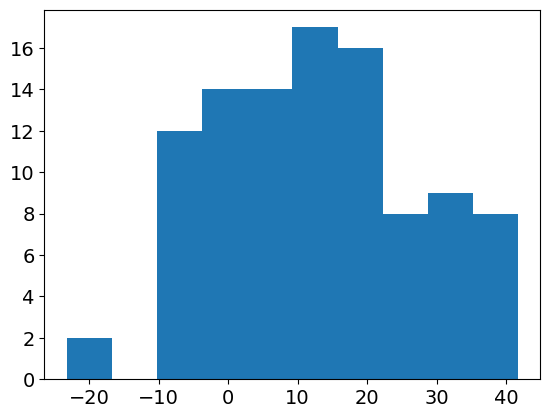

In [52]:
plt.hist(samples_i)